# Comounting correlations with FFT: Matched filtering

Given a simulated GW signal from a black hole binary buried in zero-mean, Gaussian white noise $n(t)$ with standard deviation $\sigma= 10^{-21}$ , i.e. 
$$d(t) = n(t) + mh_+ (t)/D_L$$
where $h_+ (t)=4\frac{\mu}{m}v^2 cos\phi(t)$, $m=m_1+m_2$ is the total mass of the binary, and $D_L$ is the (unknown) luminosity distance to the binary. We need to detect the location of the signal in the data by maximizing the correlation of the waveform templates computed with the above equation with the data:
$$R_{max} = max_{m,\mu,\tau}R(\tau)$$
where $R(\tau) = \int_{-\infty}^{\infty}x(t)\hat{h}(t+\tau)dt$, $\hat{h}(t):=h(t)/||h||$, $||h||^2 = \int_0^{t_c}|h(t)|^2/\sigma^2dt$, and $\sigma$ is the variance of the noise. We have the prior information that the parameters of the sigal are in the following range:$5<m/M_\odot<15, 0.2< \mu/m<0.25$. Estimate the parameters $m, \mu$ of the signal (parameters that maximize the correlation)

In [47]:
import numpy as np
from scipy.fftpack import fft,ifft
import scipy.integrate  
from scipy.integrate import odeint
import matplotlib.pyplot as plt

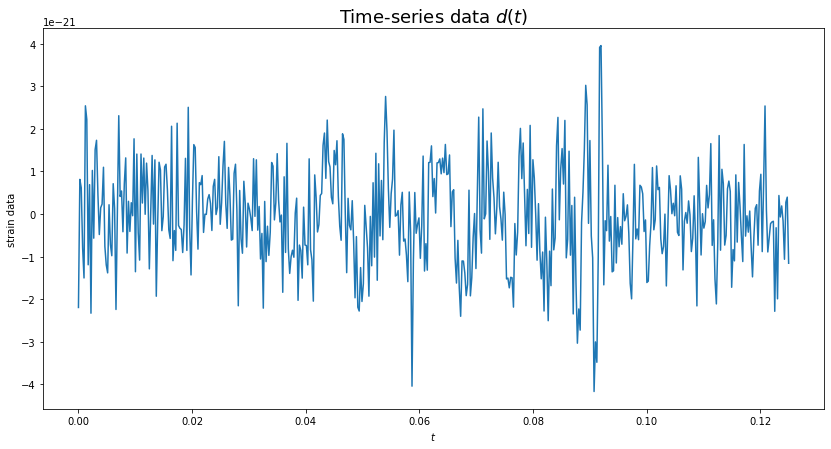

In [48]:
#plotting the data

data = np.loadtxt('/home/uddeepta/Desktop/ICTS/project_GW/computation/mock_gw_data.dat')
time = np.array(data[:,0])
sig  = np.array(data[:,1])

dt   = time[1]-time[0]
plt.figure(figsize = (14,7))
plt.plot(time, sig)
plt.xlabel('$t$')
plt.ylabel('strain data')
plt.title('Time-series data $d(t)$',fontsize = 18)
plt.show()

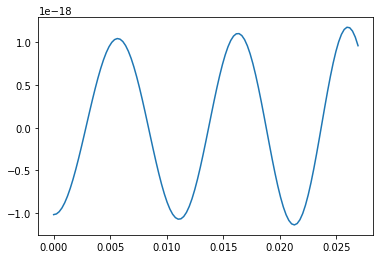

In [49]:
# We need h+ the template,for we need to get phase and velocity,which depends on total mass and reduced mass

def func(v, t, u_, m_):
    v1      = v[0]
    G       = 6.67*(10**(-11))
    c       = 3*(10**8)
    ms      = 2*(10**30)
    k       = G/(c**3)
    mass    = m_* ms * k
    u       = mass*u_
    dv_dt   = (32.*(v1**9)*u)/(5.*(mass**2))
    dphi_dt = (v1**3) / mass
    der     = [dv_dt,dphi_dt]
    return der

# function used to calculate h+ 
def hplus(vel_,phase_,red_mass_ratio):
    vel_square = vel_*vel_          
    hplus_     = 4*vel_square*np.cos(phase_)*(red_mass_ratio)
    return hplus_
#function to calculate the hx polarization
def hcross(vel_,phase_,red_mass_ratio):    
    vel_square=vel_*vel_          
    hcross_    =4*vel_square*np.sin(phase_)*(red_mass_ratio)
    return hcross_


v0      = 0.3            #initial values of velocity,phase
phi0    = 0.
initial = [v0,phi0]

red_mass_ratio = 0.25    #this is max allowed ratio of reduced mass with the total mass
tot_mass_ratio = 10      #this is the ratio of total mass with the mass of the sun 

t0 = 0.
t1=0.027
t=np.arange(0.,t1,dt) 
soln = odeint(func, initial, t, args=(red_mass_ratio,tot_mass_ratio))
vel  = soln[:,0]
phi  = soln[:,1]
h_   = hplus(vel, phi, red_mass_ratio)

stddev_        = 10**(-21)
norm_template  = scipy.integrate.simps(h_, x=None,dx = dt, even='avg')/stddev_
plt.plot(t,h_/norm_template)


In [52]:
# Here we consider all match filtering operations
def matchsignal(datafft_,template_,dt):
    stddev_        =10**(-21)
    norm_template  =scipy.integrate.simps(template_, x=None,dx=dt, even='avg')/stddev_
    template_final =template_/norm_template
    zero_padding   =np.zeros(len(datafft_)-len(template_))
    template_padded=np.append(template_,zero_padding)
    template_fft   =fft(template_padded)
    R_corr         =ifft(datafft_*np.conjugate(template_fft))
    value          =max(abs(R_corr))
    return value

In [57]:
#Now we create a loop to run through the parameters of total mass and the reduced mass
data_fft=fft(data)
param1  =np.arange(5.,15.,0.1)               #for total mass ratio to mass of sun
param2  =np.arange(.2,.25,0.0005)           #for reduced mass ratio to total mass
Rplus_tau=np.zeros((len(param1),len(param2)))    #Array to store maximum of the correlation array for each i,j
Rcross_tau=np.zeros((len(param1),len(param2)))
for i in range(len(param1)):
    for j in range(len(param2)):
        soln       =odeint(func,initial,t,args=(param2[j],param1[i]))
        vel1_      =soln[:,0]
        phase1_    =soln[:,1]
        Template_plus  =hplus(vel1_,phase1_,param2[j])[::2]
        dt         =t[2]-t[0]
        Template_cross  =hcross(vel1_,phase1_,param2[j])[::2]
        Rplus_tau[i][j]=matchsignal(data_fft,Template_plus,dt)
        Rcross_tau[i][j]=matchsignal(data_fft,Template_cross,dt)

ValueError: operands could not be broadcast together with shapes (512,2) (512,) 

In [ ]:
#here we find the index of the maximun value in the 2D array R_tau
max_ind_plus=np.unravel_index(np.argmax(Rplus_tau,axis=None),Rplus_tau.shape)
max_ind_cross=np.unravel_index(np.argmax(Rcross_tau,axis=None),Rcross_tau.shape)

print('Rplus_tau[max_ind_plus]=',Rplus_tau[max_ind_plus])
print('Rcross_tau[max_ind_cross]=',Rcross_tau[max_ind_cross])

#we see that this value of Rplus_tau and Rcross_tau is many orders higher than other values.

Rmax=max(Rcross_tau[max_ind_cross],Rplus_tau[max_ind_plus])
print('The template of h plus matches more closely,we move with this as our matched template')
print('index of the parameter on Rmax =',max_ind_plus)

In [ ]:
#Thus now we can find out the respective parameters of reduced mass ration and total mass ratios
#from the parameters array param1 and param2 
print(param1[57],param2[99])
a,b=param1[57],param2[99]

In [ ]:
#Thus we can calculate the masses of the individual masses of the individual components are the soluion
#of the eqn x^2-(m1+m2)x+m1m2=0
m1_sum_m2=a  #sum of masses in terms of mass of sun

m1_prod_m2=b*(a)**2                 #product os individual masses in terms of mass of sun
# calculate the discriminant
d = (m1_sum_m2)**2 - (4*m1_prod_m2)

# find two solutions
sol1 = (m1_sum_m2-np.sqrt(d))/(2)   
sol2 = (m1_sum_m2+np.sqrt(d))/(2)
print('The two individual masses in terms of One solar Mass are:')
print('M1=',sol1)
print('M2=',sol2)

In [ ]:
# The template which is nearest to our signal is:

soln       =odeint(fun,initial,t,args=(param2[99],param1[57]))    #singularity at t=0.04 s for param1[4]
vel_signal      =soln[:,0]
phase_signal    =soln[:,1]
Template   =hcross(vel1_,phase1_,param2[99])[::2]
